ADD INTRO TEXT

In [1]:
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem import BRICS
import rdkit
rdkit.__version__
%pylab inline

RDKit WARNING: [06:31:11] Enabling RDKit 2020.03.1dev1 jupyter extensions


Populating the interactive namespace from numpy and matplotlib


Start by reading in the set of molecules we'll work with. This dataset was described in a recent [RDKit blog post](https://rdkit.blogspot.com/2019/10/a-new-lessel-and-briem-like-dataset.html).

Bring in the molecules and do salt stripping:

In [2]:
from rdkit import rdBase
rdBase.DisableLog('rdApp.info')
ms = [rdMolStandardize.FragmentParent(x) for x in Chem.SmilesMolSupplier('../data/BLSets_selected_actives.txt')]
len(ms)

6359

In order to fragment the molecules we're going to be using the [BRICS fragmentation rules](http://doi.wiley.com/10.1002/cmdc.200800178) as implemented in the RDKit. Note that the RDKit implementation has differs from the published BRICS rules in that atom types 2 and 5 (both Ns) have been combined with each other. This is, unfortunately not (yet) documented outside of the code itself, but there's an explanation here: https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/ChemTransforms/MolFragmenter.cpp#L101

For the purposes of this evaluation as to whether or not additive fingerprints work, we will only be using the ten most common BRICS bonds in the dataset. Let's start by finding those.

This is what the list of BRICS bonds for each molecule looks like:

The first element of each tuple contains the indices of the atoms defining the bond, the second element has the BRICS atom types of those atoms. For example, the first BRICS bond in the molecule above is between atom 2 (BRICS type 1) and atom 1 (BRICS type 5).

Loop over all the molecules and count the number of times each bond type occurs:

In [3]:
from collections import defaultdict, Counter
cntr = Counter()
for m in ms:
    bbnds = BRICS.FindBRICSBonds(m)
    for aids,lbls in bbnds:
        cntr[lbls] += 1
freqs = sorted([(y,x) for x,y in cntr.items()],reverse=True)
freqs[:10]

[(7337, ('4', '5')),
 (4619, ('1', '5')),
 (3488, ('8', '16')),
 (2599, ('3', '16')),
 (1817, ('5', '16')),
 (1507, ('3', '4')),
 (997, ('6', '16')),
 (853, ('5', '15')),
 (790, ('8', '14')),
 (714, ('8', '15'))]

The top two bond types are `4-5`(alkyl C - amine) and `1-5` (the amide bond).

Keep those top 10:

In [4]:
bondsToKeep = [y for x,y in freqs[:10]]

In order to clarify what the more complex code below does, here's a worked example demonstrating fragmenting a single molecule along two bonds, both between BRICS atom types 1 and 5 (these bonds and the types come from the example above where we found the molecule's BRICS bonds):

Let's define some functions that we'll use for the rest of this:

In [24]:
def splitMol(mol,bondsToKeep):
    ''' fragments a molecule on a particular set of BRICS bonds. 
    Partially sanitizes the results 
    '''
    bbnds = BRICS.FindBRICSBonds(mol)
    bndsToTry = []
    lbls = []
    for aids,lbl in bbnds:
        if lbl in bondsToKeep:
            bndsToTry.append(mol.GetBondBetweenAtoms(aids[0],aids[1]).GetIdx())
            lbls.append([int(x) for x in lbl])
    if not bndsToTry:
        return []
    res = Chem.FragmentOnSomeBonds(mol,bndsToTry,dummyLabels=lbls)
    # We need at least a partial sanitization for the rest of what we will be doing:
    for entry in res:
        entry.UpdatePropertyCache(False)
        Chem.FastFindRings(entry)
    return res

def getDifferenceFPs(mol,bondsToKeep,fpgen):
    ''' generates the difference fingerprint between the molecule
    and each of its fragmentations based on the BRICS bond types passed in.
    
    This calculates the sum of the fragment fingerprints by just generating the
    fingerprint of the fragmented molecule, so whole-molecule fingerprints like
    atom pairs will not work here. That's fine since they are unlikely to be useful
    with this approach anyway
    '''
    frags = splitMol(mol,bondsToKeep)
    if not frags:
        return []
    res = []
    # get the fingerprint for the molecule:
    molfp = fpgen.GetCountFingerprint(mol)
    # now loop over each fragmentation
    for frag in frags:
        # generate the fingerprint of the fragmented molecule
        # (equivalent to the sum of the fingerprints of the fragments)
        ffp = fpgen.GetCountFingerprint(frag)
        # and keep the difference
        res.append(molfp-ffp)
    return res

def getSumFP(fragMol,fpgen,delta):
    ''' Constructs the sum fingerprint for a fragmented molecule using
    delta as a constant offset
    
    note that any elements of the fingerprint that are negative after adding the
    constant offset will be set to zero
    
    '''
    ffp = fpgen.GetCountFingerprint(fragMol)
    if delta is not None:
        for idx,v in delta.GetNonzeroElements().items():
            tv = ffp[idx] + v
            if tv<0:
                tv = 0;
            ffp[idx] = tv
    return ffp

import random
def run_with_fpgen(ms,fpgen,thresh,includeCorrection=True):
    results = {}
    for btk in bondsToKeep:
        print(f"Doing {btk}")
        random.seed(0xf00d)
        if includeCorrection:
            dfps = []
            for m in ms:
                dfps.extend(getDifferenceFPs(m,[btk],fpgen))
            delta1 = dfps[0]
            for dfp in dfps[1:]:
                delta1 += dfp
            nfps = len(dfps)
            for k,v in delta1.GetNonzeroElements().items():
                delta1[k] = round(v/nfps)
        else:
            delta1 = None
            
        allfps = []
        for m in ms:
            frags = splitMol(m,[btk])
            if not frags:
                continue
            fp1 = fpgen.GetCountFingerprint(m)
            ffps = [getSumFP(x,fpgen,delta1) for x in frags]
            allfps.append((fp1,ffps))

        self_tanis = []
        for fp1,ffps in allfps:
            self_tanis.extend([DataStructs.TanimotoSimilarity(fp1,x) for x in ffps])

        ps1 = list(range(len(allfps)))
        random.shuffle(ps1)
        ps1 = ps1[:1000]
        ps2 = list(range(len(allfps)))
        random.shuffle(ps2)
        ps2 = ps2[:1000]

        nCompared = 0
        other_tanidiff1 = []
        other_tanidiff2 = []
        for i in ps1:
            fp1,frags1 = allfps[i]
            for j in ps2:
                fp2,frags2 = allfps[j]
                refTani = DataStructs.TanimotoSimilarity(fp1,fp2)
                if refTani < thresh:
                    continue
                nCompared += 1
                ltanis = []
                for f1 in frags1:
                    ltanis.extend(DataStructs.BulkTanimotoSimilarity(f1,frags2))
                other_tanidiff1.extend([refTani-x for x in ltanis])
                other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp1,frags2)])
                other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp2,frags1)])

        print(f"considered {nCompared} fingerprint pairs from {len(allfps)**2}")
        results[btk] = (self_tanis,other_tanidiff1,other_tanidiff2)
    return results

# Validation

Repeat that analysis for each of the top 10 fragmentations:

In [18]:
print("-------- RDK5 ----------")
fpgen5 = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=4096)
rdk5_results = run_with_fpgen(ms,fpgen5,0.37)
print("-------- RDK7 ----------")
fpgen7 = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7,fpSize=4096)
rdk7_results = run_with_fpgen(ms,fpgen7,0.51)
print("-------- TT ----------")
fpgentt = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=4096)
tt_results = run_with_fpgen(ms,fpgentt,0.26)
print("-------- MFP2 ----------")
fpgen2 = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)
mfp2_results = run_with_fpgen(ms,fpgen2,0.31)
print("-------- MFP3 ----------")
fpgen3 = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=4096)
mfp3_results = run_with_fpgen(ms,fpgen3,0.24)

-------- RDK5 ----------
Doing ('4', '5')
considered 53217 fingerprint pairs from 18326961
Doing ('1', '5')
considered 53467 fingerprint pairs from 7845601
Doing ('8', '16')
considered 58902 fingerprint pairs from 6095961
Doing ('3', '16')
considered 79807 fingerprint pairs from 4260096
Doing ('5', '16')
considered 140587 fingerprint pairs from 2725801
Doing ('3', '4')
considered 74120 fingerprint pairs from 1537600
Doing ('6', '16')
considered 72969 fingerprint pairs from 790321
Doing ('5', '15')
considered 61868 fingerprint pairs from 640000
Doing ('8', '14')
considered 49256 fingerprint pairs from 504100
Doing ('8', '15')
considered 36316 fingerprint pairs from 352836
-------- RDK7 ----------
Doing ('4', '5')
considered 7381 fingerprint pairs from 18326961
Doing ('1', '5')
considered 11770 fingerprint pairs from 7845601
Doing ('8', '16')
considered 13151 fingerprint pairs from 6095961
Doing ('3', '16')
considered 12067 fingerprint pairs from 4260096
Doing ('5', '16')
considered 1691

In [19]:
import pickle
pickle.dump((rdk5_results,rdk7_results,tt_results,mfp2_results,mfp3_results),open('../data/dfp_results.pkl','wb+'))

Start, again, by looking at self similarities.

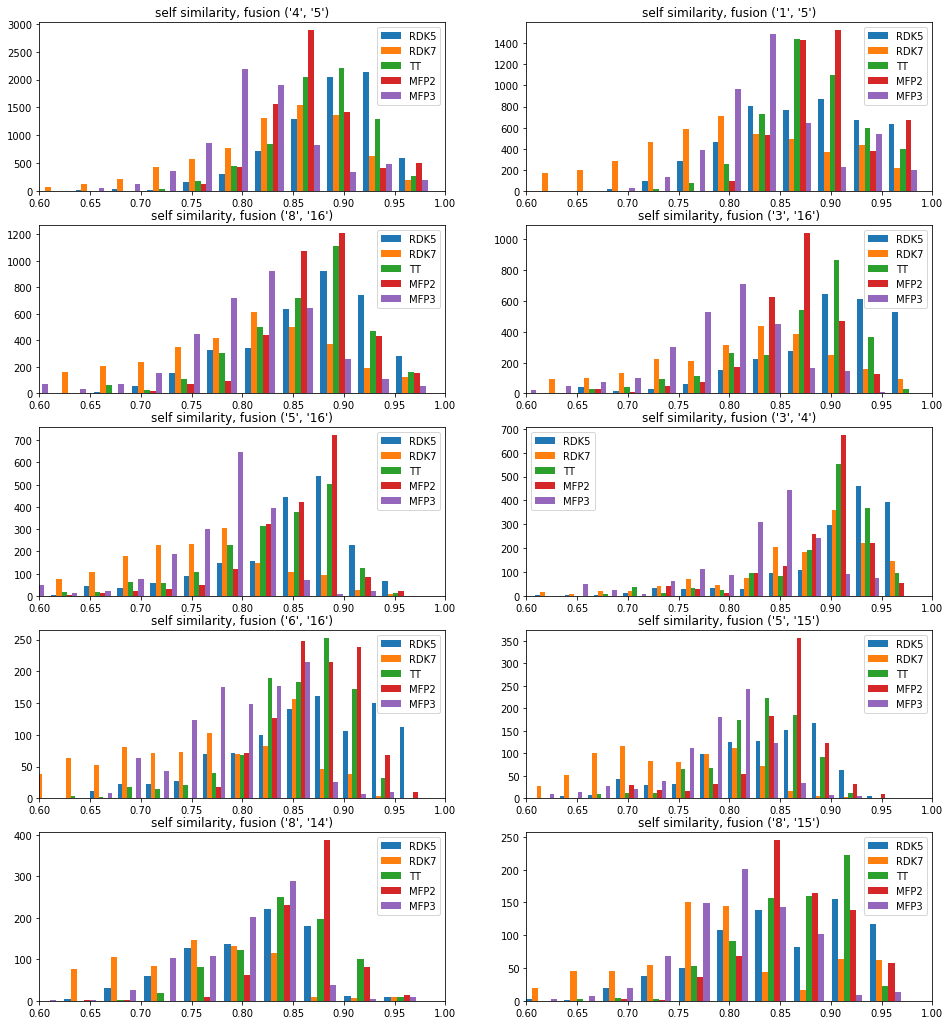

In [21]:
figsize(16,18)
for i,btk in enumerate(rdk5_results.keys()):
    subplot(5,2,i+1)
    rdk5_self_tanis,rdk5_other_tanidiff1,rdk5_other_tanidiff2 = rdk5_results[btk]
    rdk7_self_tanis,rdk7_other_tanidiff1,rdk7_other_tanidiff2 = rdk7_results[btk]
    tt_self_tanis,tt_other_tanidiff1,tt_other_tanidiff2 = tt_results[btk]
    mfp2_self_tanis,mfp2_other_tanidiff1,mfp2_other_tanidiff2 = mfp2_results[btk]
    mfp3_self_tanis,mfp3_other_tanidiff1,mfp3_other_tanidiff2 = mfp3_results[btk]

    hist([rdk5_self_tanis,rdk7_self_tanis,tt_self_tanis,mfp2_self_tanis,mfp3_self_tanis,],bins=20, 
         label=['RDK5','RDK7','TT','MFP2','MFP3']);
    title(f"self similarity, fusion {btk}");
    legend()
    xlim((0.6,1.0))

The differences here aren't huge, but we definitely aren't getting self-similarities of 1.

Still, we aren't really interested in self-similarity. How does the method do when we compute fragment-fragment similarities? This time we plot the difference between the similarities calculated with the full fingerprint and the fragment fingerprint.

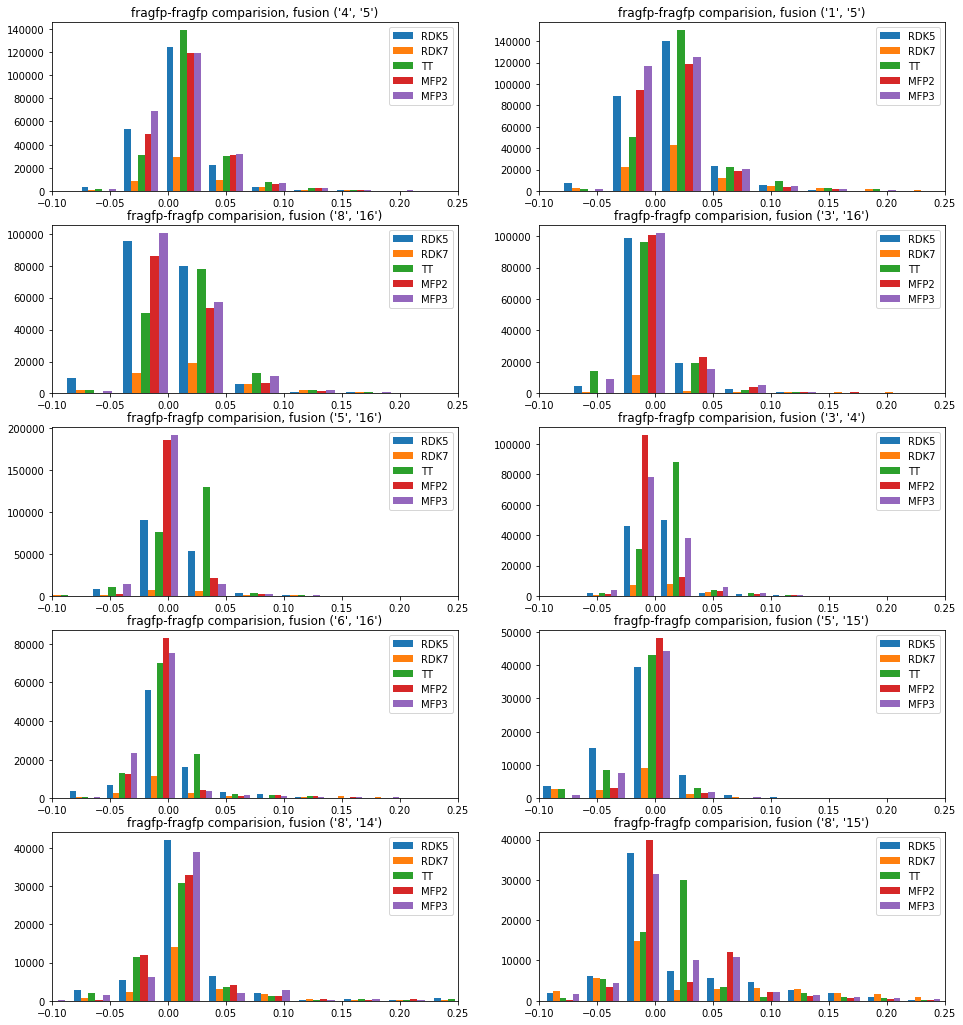

In [22]:
figsize(16,18)
for i,btk in enumerate(rdk5_results.keys()):
    subplot(5,2,i+1)
    rdk5_self_tanis,rdk5_other_tanidiff1,rdk5_other_tanidiff2 = rdk5_results[btk]
    rdk7_self_tanis,rdk7_other_tanidiff1,rdk7_other_tanidiff2 = rdk7_results[btk]
    tt_self_tanis,tt_other_tanidiff1,tt_other_tanidiff2 = tt_results[btk]
    mfp2_self_tanis,mfp2_other_tanidiff1,mfp2_other_tanidiff2 = mfp2_results[btk]
    mfp3_self_tanis,mfp3_other_tanidiff1,mfp3_other_tanidiff2 = mfp3_results[btk]

    hist([rdk5_other_tanidiff1,rdk7_other_tanidiff1,tt_other_tanidiff1,mfp2_other_tanidiff1,mfp3_other_tanidiff1,],bins=20, 
         label=['RDK5','RDK7','TT','MFP2','MFP3']);
    title(f"fragfp-fragfp comparision, fusion {btk}");
    legend()
    xlim((-0.1,0.25))


Those look good! In general the difference in similarities is within 0.05.

And, finally, since we could also query the collection of fragment molecules with a full fingerprint, look at the difference between the full FP similarity and the full FP - fragment FP similarity:

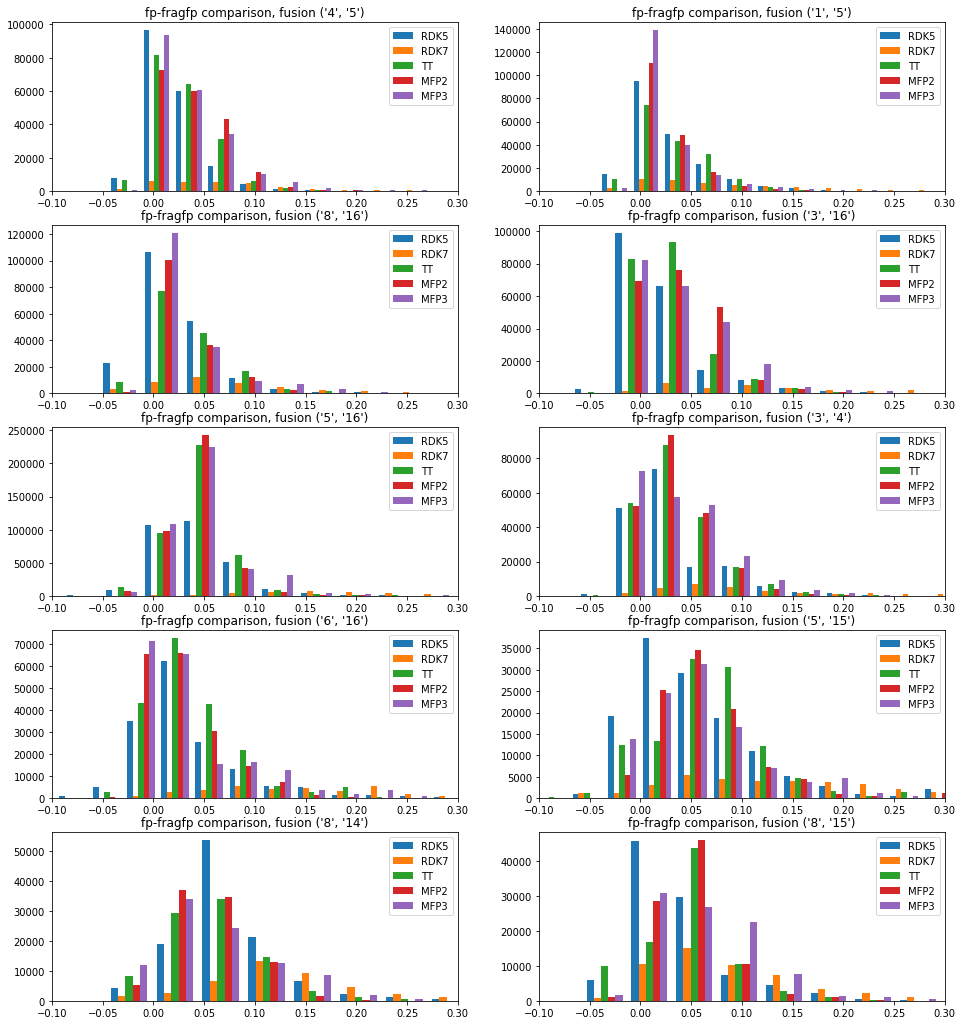

In [23]:
figsize(16,18)
for i,btk in enumerate(rdk5_results.keys()):
    subplot(5,2,i+1)
    rdk5_self_tanis,rdk5_other_tanidiff1,rdk5_other_tanidiff2 = rdk5_results[btk]
    rdk7_self_tanis,rdk7_other_tanidiff1,rdk7_other_tanidiff2 = rdk7_results[btk]
    tt_self_tanis,tt_other_tanidiff1,tt_other_tanidiff2 = tt_results[btk]
    mfp2_self_tanis,mfp2_other_tanidiff1,mfp2_other_tanidiff2 = mfp2_results[btk]
    mfp3_self_tanis,mfp3_other_tanidiff1,mfp3_other_tanidiff2 = mfp3_results[btk]

    hist([rdk5_other_tanidiff2,rdk7_other_tanidiff2,tt_other_tanidiff2,mfp2_other_tanidiff2,mfp3_other_tanidiff2,],bins=20, 
         label=['RDK5','RDK7','TT','MFP2','MFP3']);
    title(f"fp-fragfp comparison, fusion {btk}");
    legend()
    #yscale('log')
    xlim((-0.1,0.3));

Here the differences are larger than when we search with the fragment fps, but they still aren't huge. This form of the query also has the characteristic that the similarity calculated against the fragment fps is almost always lower than that calculated against the full fp.

# What about if we don't use the constant offset?

I went into this convinced that the constant offset was important. What if we just use the simple additive fingerprints without including that offset?

In [25]:
print("-------- RDK5 ----------")
fpgen5 = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=4096)
rdk5_noconstant_results = run_with_fpgen(ms,fpgen5,0.37,includeCorrection=False)
print("-------- RDK7 ----------")
fpgen7 = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7,fpSize=4096)
rdk7_noconstant_results = run_with_fpgen(ms,fpgen7,0.51,includeCorrection=False)
print("-------- TT ----------")
fpgentt = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=4096)
tt_noconstant_results = run_with_fpgen(ms,fpgentt,0.26,includeCorrection=False)
print("-------- MFP2 ----------")
fpgen2 = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)
mfp2_noconstant_results = run_with_fpgen(ms,fpgen2,0.31,includeCorrection=False)
print("-------- MFP3 ----------")
fpgen3 = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=4096)
mfp3_noconstant_results = run_with_fpgen(ms,fpgen3,0.24,includeCorrection=False)

-------- RDK5 ----------
Doing ('4', '5')
considered 53217 fingerprint pairs from 18326961
Doing ('1', '5')
considered 53467 fingerprint pairs from 7845601
Doing ('8', '16')
considered 58902 fingerprint pairs from 6095961
Doing ('3', '16')
considered 79807 fingerprint pairs from 4260096
Doing ('5', '16')
considered 140587 fingerprint pairs from 2725801
Doing ('3', '4')
considered 74120 fingerprint pairs from 1537600
Doing ('6', '16')
considered 72969 fingerprint pairs from 790321
Doing ('5', '15')
considered 61868 fingerprint pairs from 640000
Doing ('8', '14')
considered 49256 fingerprint pairs from 504100
Doing ('8', '15')
considered 36316 fingerprint pairs from 352836
-------- RDK7 ----------
Doing ('4', '5')
considered 7381 fingerprint pairs from 18326961
Doing ('1', '5')
considered 11770 fingerprint pairs from 7845601
Doing ('8', '16')
considered 13151 fingerprint pairs from 6095961
Doing ('3', '16')
considered 12067 fingerprint pairs from 4260096
Doing ('5', '16')
considered 1691

In [26]:
import pickle
pickle.dump((rdk5_noconstant_results,rdk7_noconstant_results,tt_noconstant_results,
             mfp2_noconstant_results,mfp3_noconstant_results),open('../data/dfp_noconstant_results.pkl','wb+'))

In [ ]:
figsize(16,18)
for i,btk in enumerate(noconstant_results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    self_tanis_2,other_tanidiff1_2,other_tanidiff2_2 = noconstant_results[btk]
    hist([self_tanis,self_tanis_2],bins=20, label=['with constant','no constant']);
    title(f"self similarity, fusion {btk}");
    legend()
    xlim((0.6,1.0))

Here the red histograms are clearly shifted to the left; the constant is helping.

In [ ]:
figsize(16,18)
for i,btk in enumerate(noconstant_results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    self_tanis_2,other_tanidiff1_2,other_tanidiff2_2 = noconstant_results[btk]
    hist([other_tanidiff1,other_tanidiff1_2],bins=20, label=['with constant','no constant']);
    legend();
    title(f"fragfp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.25));

Here the differences aren't as pronounced. It looks like the constant term has the consequence of making the similarity a bit lower(the red histograms are shifted a bit to the left). The difference is, in any case, not large

In [ ]:
figsize(16,18)
for i,btk in enumerate(noconstant_results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    self_tanis_2,other_tanidiff1_2,other_tanidiff2_2 = noconstant_results[btk]
    hist([other_tanidiff2,other_tanidiff2_2],bins=20, label=['with constant','no constant']);
    legend();
    title(f"fp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.3));

Here we again have a clear signal: leaving the constant term out causes a larger similarity difference (the red histograms are mostly shifted to the right).

In [ ]:
import random
random.seed(0xf00d)
results = {}
for btk in bondsToKeep:
    print(f"Doing {btk}")
    fpgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=4096)
    dfps= []
    for m in ms:
        dfps.extend(getDifferenceFPs(m,[btk],fpgen))

    delta1 = dfps[0]
    for dfp in dfps[1:]:
        delta1 += dfp
    nfps = len(dfps)
    for k,v in delta1.GetNonzeroElements().items():
        delta1[k] = round(v/nfps)

    allfps = []
    for m in ms:
        frags = splitMol(m,[btk])
        if not frags:
            continue
        fp1 = fpgen.GetCountFingerprint(m)
        ffps = [getSumFP(x,fpgen,delta1) for x in frags]
        allfps.append((fp1,ffps))

    self_tanis = []
    for fp1,ffps in allfps:
        self_tanis.extend([DataStructs.TanimotoSimilarity(fp1,x) for x in ffps])
        
    ps1 = list(range(len(allfps)))
    random.shuffle(ps1)
    ps1 = ps1[:1000]
    ps2 = list(range(len(allfps)))
    random.shuffle(ps2)
    ps2 = ps2[:1000]

    nCompared = 0
    other_tanidiff1 = []
    other_tanidiff2 = []
    for i in ps1:
        fp1,frags1 = allfps[i]
        for j in ps2:
            fp2,frags2 = allfps[j]
            refTani = DataStructs.TanimotoSimilarity(fp1,fp2)
            if refTani < 0.27:
                continue
            nCompared += 1
            ltanis = []
            for f1 in frags1:
                ltanis.extend(DataStructs.BulkTanimotoSimilarity(f1,frags2))
            other_tanidiff1.extend([refTani-x for x in ltanis])
            other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp1,frags2)])
            other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp2,frags1)])

    print(f"considered {nCompared} fingerprint pairs from {len(allfps)**2}")
    results[btk] = (self_tanis,other_tanidiff1,other_tanidiff2)


In [ ]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(self_tanis,bins=20);
    title(f"self similarity, fusion {btk}");    
    xlim((0.6,1.0))

In [ ]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(other_tanidiff1,bins=20);
    title(f"fragfp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.25));

In [ ]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(other_tanidiff2,bins=20);
    title(f"fp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.3));